---
title: "Subsetting ICESat-2 Data Using NASA Harmony"
---

## Summary

In this tutorial, we will use NASA's Earthdata Harmony Services to subset and access data using the `harmony-py` Python library. We will subset the [ATL03 Global Geolocated Photon Data](https://nsidc.org/data/atl03/versions/6) product from the [ICESat-2 mission](https://nsidc.org/data/icesat-2) as an example. Please see [Demonstration for working with TEMPO data via Harmony-py](https://nasa.github.io/ASDC_Data_and_User_Services/TEMPO/how_to_examine_TEMPO_data_using_harmony-py.html) as a complimentary tutorial highlighting Harmony services for the [TEMPO mission](https://asdc.larc.nasa.gov/project/TEMPO). 

**What is Harmony?**  [Harmony](https://harmony.earthdata.nasa.gov/) is a service that allows you to customize many NASA datasets, including the ability to subset, reproject and reformat files.  Data can be subsetted for a geographic region, a temporal range and by variable.  Data can be "reprojected" from its native coordinate reference system (CRS) to the coordinate reference system relevant to your analysis.  And data can be reformatted from its native file format to a format that is more relevant for your application.  These services are collectively called _transformation services_.  However, not all services are available for all datasets.  You will learn how to discover which services are available for a given dataset.

Data transformed by Harmony services are staged on NASA Amazon Web Services (AWS) S3 buckets or on user-owned AWS S3 buckets.  Data in NASA S3 buckets are accessed using signed URLs or temporary access credentials.  This data can be downloaded to your local machine or you can access the data directly if you are working in an AWS cloud instance, such as a Jupyter Hub, in AWS `us-west-2`.  

## Learning Objectives

In this tutorial you will learn how to:

1. discover Harmony service options for a given dataset;
3. use the `harmony-py` library to subset ATL03 granules for a bounding box and time range;
4. download the subsetted ATL03 to your local machine;
5. load the subsetted ATL03 data directly into xarray.

## Prerequisites

This tutorial has been designed to run in an AWS cloud compute instance in AWS region `us-west-2`.  However, if you want run it from your laptop or workstation, everything except Step-4, direct access, should work just fine.

An [Earthdata Login](https://urs.earthdata.nasa.gov) account is required to access data from the NASA Earthdata system. Before requesting a subset of ICESat-2 data, we first need to set up our Earthdata Login authentication, shown below.

## Tutorial

### Step 1: import required packages

We'll be using `earthaccess`, `harmony-py` and `xarray`, along with some Python standard libraries. 

In [1]:
# Harmony services (added Environment for testing in UAT; can remove for pull request)
from harmony import BBox, Client, Collection, Request, LinkType, CapabilitiesRequest, Environment 

# Earthdata Login Authentication
import earthaccess 

# Load the data
import xarray as xr
#added rasterio to open a GeoTIFF
import rasterio

import netrc
import json
import datetime as dt
import s3fs

from IPython.display import display, JSON
#added rasterio.plot to visualize the GeoTIFF
import rasterio.plot

### Step 2: start a Harmony client

A Harmony [`Client`](https://harmony-py.readthedocs.io/en/latest/api.html#harmony.Client) is the interface to Harmony services and is used to submit requests and retrieve the results of those requests.  We only need to start the client once.  That client can then be used to discover what options are available for a dataset, request subsetting, check on the status of that request and retrieve the results.

We need to supply our Earthdata Login credentials to use Harmony services.  `hamony.Client` will use EDL_USERNAME & EDL_PASSWORD environment variables or the credentials in our `.netrc` file, if one is available.  If we don't have either of these set up, we can enter our credentials directly.

```
harmony_client = Client(auth=('edl_username','edl_password'))
```

:::{note}
If you don't have environment variables or a `.netrc` file setup, replace the command in the following code cell with the one above, and use your actual username and password.
:::

In [2]:
harmony_client = Client()

### Step 3: discover service options for a given dataset

The first thing we want to know is what service options Harmony has for the ICESat-2 dataset.  We discover service options for a dataset by submitting a `CapabilitiesRequest`.  

A `CapabilitiesRequest` takes a single argument that is either the _Collection ID_ (also known as the _Concept ID_) or the _Short Name_ for the dataset.  A _Concept ID_ is a unique identifier for a dataset.  For ATL03 Version 6, it is C2596864127-NSIDC_CPRD.  For ICESat-2 products, the _Short Name_ is the familiar product name starting with ATL; e.g. ATL03.

Submitting requests to Harmony will follow the same pattern, whether we are discovering capabilities or subsetting data.  We first create a request and then submit that request.

In [3]:
short_name = "ATL03"
capabilities_request = CapabilitiesRequest(short_name=short_name)

We then submit the request using the request method of the Harmony client.

In [4]:
capabilities = harmony_client.submit(capabilities_request)

The result is returned as a [JSON](https://en.wikipedia.org/wiki/JSON) string.  This string is human readable text but the format makes it hard to read the contents.  We can use the `json` library to _decode_ the string and print it in a more reader-friendly format.

:::{warning}
The JSON returned by capabilities can be very long if variable subsetting is an option and data
files contains lots of variables.  However, information about subsetting service options should be in the first few lines of output.
:::

In [5]:
JSON(capabilities)

<IPython.core.display.JSON object>

The JSON response contains a list of transformation options available for each dataset: marked as `true` if available and `false` if not.  A list of Harmony service _endpoints_ and capabilities associated with the transformation options.  And a list of variables in the dataset if variable subsetting is available.

For ATL03, you can see that only subsetting bounding box (`bboxSubset`) and subsetting by Shapefile (`shapeSubset`) are marked `true`.  Variable subsetting (`variableSubset`), concatenation (`concatenate`) and reprojection (`reproject`) are all `false`.   Bounding box and Shapefile subsetting, as well as temporal subsetting, are performed by the Trajectory Subsetter.  This subsetting routine outputs an HDF5 file.

### Step 4: subset data

Now that we know what subsetting options are available for the ATL03 dataset, we can request a subsetted dataset.  

#### Create A Subset Request

we will create a simple request for subset of ATL03 for a bounding box over the northern Colorado Front Range and for the 2020-04-27 to 2020-05-28 period.

![Bounding Box and ATL03 Ground Track for northern Colorado](images/atl03_ground_track_and_bbox.png)

The spatial extent to subset is passed as a `BBox` object that defines the _minimum longitude_, _minimum latitude_, _maximum longitude_ and _maximum latitude_ in decimal degrees.

The temporal range to subset is passed to Harmony as a dictionary with `"start"` and `"stop"` keys, and dates supplied as `datetime` objects.  

Currently, ICESat-2 data only allows spatial and temporal subsetting so we only demonstrate these capabilities.  For further information on constructing a `Request` objects see the [harmony-py](https://harmony-py.readthedocs.io/en/latest/) documentation.

In [6]:
request = Request(
  collection = Collection(id=capabilities["conceptId"]),
  spatial=BBox(-105.5,40,-105,41.),
  temporal={
    'start': dt.datetime(2020, 4, 27),
    'stop': dt.datetime(2020, 5, 28)
  }
)

#### Submit the request

The request is submitted in the same way as the Capabilities request.  This starts the subsetting process, which may take a while depending on the size of the request.  Submitting the request returns a Job ID, which is a unique identifier for your request that is used to track the progress of the request and to access the results.

If the request involves a lot of files (more than 300), Harmony will only process the first 300 files.  See section below on Handling Large Jobs on how to work around this restriction.

In [7]:
job_id = harmony_client.submit(request)
job_id

'281fbbed-4c1b-4fc4-9f51-ebdf056f48bf'

### Step 5: check the status of the request

Subsetting is performed in the cloud.  For small jobs, the subsetting process can be monitored with a progress bar by submitting the `job_id` to the `wait_for_processing` method of the Harmony client.

In [8]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


Once the subsetting has finished, information about the job can be accessed as a JSON file

In [9]:
job_summary = harmony_client.result_json(job_id)
JSON(job_summary)

<IPython.core.display.JSON object>

### Step 6: access the subsetted data

The subsetted files can be accessed by downloading the files to a local machine, such as a laptop or desktop workstation, or by _streaming_ the data.  We will use both access methods in the two examples below.  

Results are staged for 30 days in the Harmony s3 bucket.

#### Download a single file

The _download_ method takes a url to a single subsetted file.  The `directory` keyword is used to specify a download path.  The default is the current working directory (`.`).  Setting `overwrite` to False avoids downloading the same file twice.  If you need to download the file again, then set `overwrite=True`.

:::{note}
The `download` and `download_all` method are [_asynchronous_](https://en.wikipedia.org/wiki/Asynchrony_(computer_programming)), so that downloading each file is performed independently.  Once the downloads are completed, the filepaths for the downloaded file are accessed using the `result` method.
:::

In [10]:
url = list(harmony_client.result_urls(job_id))[0]  # Get the data url of the first file
filepath = harmony_client.download(url, directory=".", overwrite=False).result()
filepath

./110261526_ATL03_20200427193622_04930702_006_02_subsetted.h5


'./110261526_ATL03_20200427193622_04930702_006_02_subsetted.h5'

./110261526_ATL03_20200427193622_04930702_006_02_subsetted.h5


#### Download all files

The `download_all` method can use the _job-id_ or the _result-json_, which contains result urls.  

As with `download`, the download directory path on the local machine can be specified with the `directory` keyword.  To save downloading the same file, the `overwrite` keyword can be set to False.

The paths fo the files are returned as a list.

In [11]:
futures = harmony_client.download_all(job_id, directory=".", overwrite=False)
filelist = [f.result() for f in futures]  # get filepaths
len(filelist)

1

In this case, there is only one file download.  Individual filepaths can be accessed using the normal methods for Python lists.

In [12]:
filelist[0]

'./110261526_ATL03_20200427193622_04930702_006_02_subsetted.h5'

#### Load a file into an `xarray` dataset

The simplest way to load ICESat-2 data is to use `xarray`.

:::{note}
You could also load the data into a `geopandas.GeoDataframe`
:::

In [13]:
ds = xr.open_dataset(filelist[0], group="gt1l/heights")
ds

<xarray.Dataset> Size: 92MB
Dimensions:         (delta_time: 1848993, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 15MB 2020-04-27T19:39:45.8497...
    lat_ph          (delta_time) float64 15MB ...
    lon_ph          (delta_time) float64 15MB ...
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (delta_time) float32 7MB ...
    dist_ph_along   (delta_time) float32 7MB ...
    h_ph            (delta_time) float32 7MB ...
    pce_mframe_cnt  (delta_time) uint32 7MB ...
    ph_id_channel   (delta_time) uint8 2MB ...
    ph_id_count     (delta_time) uint8 2MB ...
    ph_id_pulse     (delta_time) uint8 2MB ...
    quality_ph      (delta_time) int8 2MB ...
    signal_conf_ph  (delta_time, ds_surf_type) int8 9MB ...
    weight_ph       (delta_time) uint8 2MB ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

#### Direct S3 Access of Harmony Results

If you are working in the AWS `us-west-2` region (the same region as NASA Earthdata Cloud) you can _stream_ the data using direct S3 access.

:::{warning}
You must be running this notebook in the AWS us-west-2 region to run the following code cells.
:::



We need to get the url for the data in the S3 bucket.  We can do this using `result_urls`, as we did for `download` but we set `link_type=LinkType.s3` to specify we want the S3 url.

In [14]:
urls = list(harmony_client.result_urls(job_id, link_type=LinkType.s3))  # result_urls returns a generator possible issue to return list
urls

['s3://harmony-prod-staging/public/281fbbed-4c1b-4fc4-9f51-ebdf056f48bf/110261526/ATL03_20200427193622_04930702_006_02_subsetted.h5']

We need AWS credentials to access the S3 bucket with the results.  These are returned using the `aws_credentials` method.

In [15]:
creds = harmony_client.aws_credentials()

We then create a virtual file system that allows us to access the S3 bucket.  We pass the credentials to authenticate.

In [16]:
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

We then open the S3 url as a _file-like_ object.

:::{note}
A _file-like_ object is just what it sounds like, an _object_ - a collection of bytes in memory - that is recognized as a file by applications.
:::

In [17]:
f = [s3_fs.open(url, mode='rb') for url in urls]

We can then open one of the files using `xarray`. 

In [18]:
ds = xr.open_dataset(f[0], group='gt1l/heights')
ds

<xarray.Dataset> Size: 92MB
Dimensions:         (delta_time: 1848993, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 15MB 2020-04-27T19:39:45.8497...
    lat_ph          (delta_time) float64 15MB ...
    lon_ph          (delta_time) float64 15MB ...
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (delta_time) float32 7MB ...
    dist_ph_along   (delta_time) float32 7MB ...
    h_ph            (delta_time) float32 7MB ...
    pce_mframe_cnt  (delta_time) uint32 7MB ...
    ph_id_channel   (delta_time) uint8 2MB ...
    ph_id_count     (delta_time) uint8 2MB ...
    ph_id_pulse     (delta_time) uint8 2MB ...
    quality_ph      (delta_time) int8 2MB ...
    signal_conf_ph  (delta_time, ds_surf_type) int8 9MB ...
    weight_ph       (delta_time) uint8 2MB ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

## Appendices

### A. Handling large requests

By default Harmony will only process first 300 granules for large requests.  This allows users to check that results look correct.  Once we are satified that our request is correct, the job can be resumed.  See this [notebook](https://github.com/nasa/harmony-py/blob/main/examples/job_pause_resume.ipynb) for examples.

### B. Translating requests

`harmony-py` is an interface to the Harmony RESTful API.  RESTful API send requests and receive responses via HTTPS; the same protocol that serves web pages.  Requests are sent to service endpoints, which is a URL (e.g. `https://service.endpoint.com/type_of_service`).  Query parameters that modify a request can be appended a key-value pairs after a `?`.  Each key-value pair is separated by an &.  For example:

```
https://service.endpoint.com/type_of_service?param1=value1&param2=value2
```

This url could be entered into a web browser.

The Harmony client has a `request_as_url` method that returns the request created by `CapabilitiesRequest` or `Request`

In [19]:
harmony_client.request_as_url(capabilities_request)

'https://harmony.earthdata.nasa.gov/capabilities?shortname=ATL03'

In [20]:
harmony_client.request_as_url(request)

'https://harmony.earthdata.nasa.gov/C2596864127-NSIDC_CPRD/ogc-api-coverages/1.0.0/collections/parameter_vars/coverage/rangeset?forceAsync=true&subset=lat%2840%3A41.0%29&subset=lon%28-105.5%3A-105%29&subset=time%28%222020-04-27T00%3A00%3A00%22%3A%222020-05-28T00%3A00%3A00%22%29&label=harmony-py&variable=all'

Try pasting the URL in the output cell below into a web browser to see the response.

Harmony requests can also be sent with `curl`, a library and command line tool for transfering data using various network protocols, including HTTPS.  The `request_as_curl` method can be used to generate a curl command.  This can be helpful if you want to automate a process outside of a Jupyter Notebook or for testing requests.

In [21]:
harmony_client.request_as_curl(capabilities_request)

"curl -X GET -H 'Accept: */*' -H 'Accept-Encoding: gzip, deflate, br, zstd' -H 'Connection: keep-alive' -H 'Cookie: state=s%3A2b0ec71d18c39b1e6a529c51104f7cc1.mFcNqQyXttThGxGiMbvzxK3EGJZFOETiWTstlPrM%2BF4; token=*****; urs_user_already_logged=yes; _urs-gui_session=34bf77adc3cdfdffad4389889ec7e584' -H 'User-Agent: python-requests/2.32.5 CPython/3.11.13 harmony-py/1.2.0 Linux/5.10.235-227.919.amzn2.x86_64' 'https://harmony.earthdata.nasa.gov/capabilities?shortname=ATL03'"

In [22]:
harmony_client.request_as_curl(request)

'curl -X POST -H \'Accept: */*\' -H \'Accept-Encoding: gzip, deflate, br, zstd\' -H \'Connection: keep-alive\' -H \'Content-Length: 659\' -H \'Content-Type: multipart/form-data; boundary=7614ae6db1375898faaa116c40b3e88d\' -H \'Cookie: state=s%3A2b0ec71d18c39b1e6a529c51104f7cc1.mFcNqQyXttThGxGiMbvzxK3EGJZFOETiWTstlPrM%2BF4; token=*****; urs_user_already_logged=yes; _urs-gui_session=34bf77adc3cdfdffad4389889ec7e584\' -H \'User-Agent: python-requests/2.32.5 CPython/3.11.13 harmony-py/1.2.0 Linux/5.10.235-227.919.amzn2.x86_64\' -d \'--7614ae6db1375898faaa116c40b3e88d\r\nContent-Disposition: form-data; name="forceAsync"\r\n\r\ntrue\r\n--7614ae6db1375898faaa116c40b3e88d\r\nContent-Disposition: form-data; name="subset"\r\n\r\nlat(40:41.0)\r\n--7614ae6db1375898faaa116c40b3e88d\r\nContent-Disposition: form-data; name="subset"\r\n\r\nlon(-105.5:-105)\r\n--7614ae6db1375898faaa116c40b3e88d\r\nContent-Disposition: form-data; name="subset"\r\n\r\ntime("2020-04-27T00:00:00":"2020-05-28T00:00:00")\r\n

### C. Additional data set examples: SMAP and Harmony

Harmony services are available for additional NASA Earthdata collections including for the Soil Moisture Active Passive (SMAP) mission data hosted at NSIDC DAAC. SMAP data set transformation services are listed [here](https://nsidc.org/data/user-resources/help-center/what-data-subsetting-reformatting-and-reprojection-services-are-available-smap-data).

The following examples demonstrate some Harmmony service capabilities available for SMAP data.
                                                                                                                                                                            

#### SMAP L2 data and Harmony example
##### Variable subsetting and reformat to GeoTIFF

Start your Harmony client

In [23]:
#setting environment to UAT for testing
#will change to harmony_client = Client() for prod when finalizing pull request

harmony_client = Client(env=Environment.UAT)

Discover service options for a SMAP L2 data set by creating and submitting a CapabilitiesRequest.  Here we'll look at SMAP L2 Radiometer Half-Orbit 36 km EASE-Grid Soil Moisture, Version 9, which has the short name SPL2SMP.

First, create the request.

In [24]:
short_name = "SPL2SMP"
capabilities_request = CapabilitiesRequest(short_name=short_name)

Next, submit the capabilities request and display in json format.

In [25]:
capabilities = harmony_client.submit(capabilities_request)
JSON(capabilities)

<IPython.core.display.JSON object>

Note:  As mentioned above, not all transformation services are available for all data sets. SMAP data set transformation services are listed [here](https://nsidc.org/data/user-resources/help-center/what-data-subsetting-reformatting-and-reprojection-services-are-available-smap-data).

The transformation services available to SMAP L2 swath data are:
* spatial subsetting using bounding box corner points or a polygon file (GeoJSON, kml, ESRI shapefile)
* temporal subsetting
* variable (parameter) subsetting
* reprojection to EPSG:4326
* reformat to GeoTIFF (if GeoTIFF is not selected, the output will be netcdf4)

Create a subset request.  Here we are going to select one variable from a SPL2SMP granule and reformat the output to GeoTIFF.

In [26]:
request = Request(
    collection = Collection(id=capabilities["conceptId"]),
    variables=['Soil_Moisture_Retrieval_Data/landcover_class'],
    max_results=1,
    format='image/tiff'
)

request.is_valid()

True

Submit the subset request and check the progress.

In [27]:
job_id = harmony_client.submit(request)
job_id

harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


Access the job information.

In [28]:
job_summary = harmony_client.result_json(job_id)
JSON(job_summary)

<IPython.core.display.JSON object>

Access the output.  Here we demonstrate download to a local machine.  The data can also be accessed directly as described in the ICESat-2 data example above.

In [29]:
futures = harmony_client.download_all(job_id, directory=".", overwrite=False)
filelist = [f.result() for f in futures]  # get filepaths
len(filelist)
filelist[0]

./7894451_SMAP_L2_SM_P_47183_A_20231201T171449_R19240_002_Soil_Moisture_Retrieval_Data_landcover_class_subsetted_regridded_Soil_Moisture_Retrieval_Data_landcover_class_reformatted.tif


'./7894451_SMAP_L2_SM_P_47183_A_20231201T171449_R19240_002_Soil_Moisture_Retrieval_Data_landcover_class_subsetted_regridded_Soil_Moisture_Retrieval_Data_landcover_class_reformatted.tif'

./7894466_SMAP_L4_C_mdl_20150401T000000_Vv8020_001_subsetted.nc4
./7894466_SMAP_L4_C_mdl_20150401T000000_Vv8020_001_subsetted.nc4


Plot the GeoTIFF using rasterio.

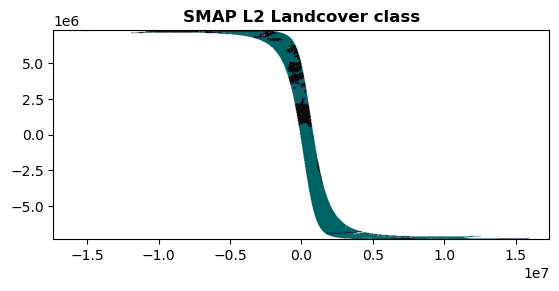

<Axes: title={'center': 'SMAP L2 Landcover class'}>

In [30]:
data_name = filelist[0]
tiff = rasterio.open(data_name)
rasterio.plot.show(tiff, title = "SMAP L2 Landcover class")

#### SMAP L3 data and Harmony example

##### Spatial and variable subsetting with conversion to EPSG:4326 and reformat to GeoTIFF

Submit a CapabilitiesRequest to discover service options for a SMAP L3 data set (SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 9). 

In [31]:
short_name = "SPL3SMP"
capabilities_request = CapabilitiesRequest(short_name=short_name)

Submit the capabilities request and display in JSON format.

In [32]:
capabilities = harmony_client.submit(capabilities_request)
JSON(capabilities)

<IPython.core.display.JSON object>

Create and submit your Harmony customization request.

In [33]:
request = Request(
    collection = Collection(id=capabilities["conceptId"]),
    granule_name = ['SMAP_L3_SM_P_20231212_R19240_001.h5'],
    spatial = BBox(-93, 30, -77, 45),
    variables = ['Soil_Moisture_Retrieval_Data_AM/soil_moisture'],
    crs='EPSG:4326',
    format ='image/tiff'
)

request.is_valid()

True

In [34]:
job_id = harmony_client.submit(request)
job_id

harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


Access job information.

In [35]:
job_summary = harmony_client.result_json(job_id)
JSON(job_summary)

<IPython.core.display.JSON object>

Access the data by downloading or via direct access from an AWS ec2 instance in region us-west-2.

#### SMAP L4 data and Harmony example

##### Spatial subsetting.  Note that the output of this subsetter will be a netcdf file, even if no reformatting is requested.

Submit a CapabilitiesRequest to discover service options for a SMAP L4 data set (SMAP L4 Global Daily 9 km EASE-Grid Carbon Net Ecosystem Exchange, Version 8).

In [36]:
short_name = "SPL4CMDL"
capabilities_request = CapabilitiesRequest(short_name=short_name)

Submit the capabilities request and display in JSON format.

In [37]:
capabilities = harmony_client.submit(capabilities_request)
JSON(capabilities)

<IPython.core.display.JSON object>

Create the Harmony request.

In [38]:
request = Request(
    collection = Collection(id=capabilities["conceptId"]),
    granule_name = ['SMAP_L4_C_mdl_20150401T000000_Vv8020_001.h5'],
    spatial = BBox(-127.0, 25.0, -65.0, 49.8)
)

request.is_valid()

True

Submit the request.

In [39]:
job_id = harmony_client.submit(request)
job_id

harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


Access job information.

In [40]:
job_summary = harmony_client.result_json(job_id)
JSON(job_summary)

<IPython.core.display.JSON object>

Download the netcdf file.

In [42]:
futures = harmony_client.download_all(job_id, directory=".", overwrite=True)
filelist = [f.result() for f in futures]  # get filepaths
len(filelist)
filelist[0]

'./7894466_SMAP_L4_C_mdl_20150401T000000_Vv8020_001_subsetted.nc4'